### Imports and loading dataset

In [1]:
# Import files
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.cluster import KMeans
from scipy.stats import zscore
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering 
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import pdist
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [2]:
# run this cell to to mount the google drive if you are using google colab
from google.colab import drive
drive.mount('/content/drive')
project_path = '/content/drive/My Drive/assignments/'

Mounted at /content/drive


In [3]:
#Loading data
cars = pd.read_csv(project_path + "cars-dataset.csv")

### EDA & Pre-processing

In [4]:
# Inspect data display the head of the data
cars.head()

,car name,cyl,disp,hp,wt,acc,yr,mpg
0,chevrolet chevelle malibu,8,307.0,130,3504,12.0,70,18.0
1,buick skylark 320,8,350.0,165,3693,11.5,70,15.0
2,plymouth satellite,8,318.0,150,3436,11.0,70,18.0
3,amc rebel sst,8,304.0,150,3433,12.0,70,16.0
4,ford torino,8,302.0,140,3449,10.5,70,17.0


In [5]:
# Inspecting the cars dataframe
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   car name  398 non-null    object 
 1   cyl       398 non-null    int64  
 2   disp      398 non-null    float64
 3   hp        398 non-null    object 
 4   wt        398 non-null    int64  
 5   acc       398 non-null    float64
 6   yr        398 non-null    int64  
 7   mpg       398 non-null    float64
dtypes: float64(3), int64(3), object(2)
memory usage: 25.0+ KB


We can see that there are 8 columns and 398 rows in the data frame. 

"car name" column is string

There are 7 other columns 6 of which are numeric values and 1 column "hp" is object. Inspecting the values for hp should be numeric. 

In [6]:
# Checking the non-numeric values of column 'hp'
cars[cars['hp'].apply(lambda x: not x.isnumeric())]

,car name,cyl,disp,hp,wt,acc,yr,mpg
32,ford pinto,4,98.0,?,2046,19.0,71,25.0
126,ford maverick,6,200.0,?,2875,17.0,74,21.0
330,renault lecar deluxe,4,85.0,?,1835,17.3,80,40.9
336,ford mustang cobra,4,140.0,?,2905,14.3,80,23.6
354,renault 18i,4,100.0,?,2320,15.8,81,34.5
374,amc concord dl,4,151.0,?,3035,20.5,82,23.0


In [7]:
cars['hp'].mode()

0    150
dtype: object

In [8]:
# We can see that some of the values contain ? as the value in hp column
# Replace these values with the mode value
cars.replace('?', cars['hp'].mode()[0], inplace=True)

In [9]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   car name  398 non-null    object 
 1   cyl       398 non-null    int64  
 2   disp      398 non-null    float64
 3   hp        398 non-null    object 
 4   wt        398 non-null    int64  
 5   acc       398 non-null    float64
 6   yr        398 non-null    int64  
 7   mpg       398 non-null    float64
dtypes: float64(3), int64(3), object(2)
memory usage: 25.0+ KB


We can see that even though the column values are converted the numeric the column is still not showing as numeric. Converting the values to numeric.

In [10]:
# Convering the hp column to numeric values
cars['hp'] = pd.to_numeric(cars['hp'])

In [11]:
# Checking the cars dataframe now
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   car name  398 non-null    object 
 1   cyl       398 non-null    int64  
 2   disp      398 non-null    float64
 3   hp        398 non-null    int64  
 4   wt        398 non-null    int64  
 5   acc       398 non-null    float64
 6   yr        398 non-null    int64  
 7   mpg       398 non-null    float64
dtypes: float64(3), int64(4), object(1)
memory usage: 25.0+ KB


We can see all the columns are now numeric.


In [13]:
# Describe the columns
cars.describe()

,cyl,disp,hp,wt,acc,yr,mpg
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,5.454774,193.425879,105.155779,2970.424623,15.568090,76.010050,23.514573
std,1.701004,104.269838,38.600986,846.841774,2.757689,3.697627,7.815984
min,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,9.000000
25%,4.000000,104.250000,76.000000,2223.750000,13.825000,73.000000,17.500000
50%,4.000000,148.500000,95.000000,2803.500000,15.500000,76.000000,23.000000
75%,8.000000,262.000000,130.000000,3608.000000,17.175000,79.000000,29.000000
max,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,46.600000


Describing the data we can see that there are quite a few outliers in dataset as can be seen from disp, hp, wt and mpg columns. Lets remove the ouliers which impacy clusytering

Min range outliers = Q1 - 1.5*IQR = Q1 - 1.5*(Q2-Q1)

Max range outliers = Q2 + 1.5*IQR = Q1 + 1.5*(Q2-Q1)

In [14]:
# Treating the outliers by dropping the values.
for label in cars:
  if (label != 'car name' and label != 'cyl' and label != 'yr'): #Do not consider the column car name as its not numerical and cyl and yr are multivalues discrete columns
    IQR = cars.describe()[label]['75%'] - cars.describe()[label]['25%']
    cars = cars[cars[label] > (cars.describe()[label]['25%'] - 1.5*IQR)]
    cars = cars[cars[label] < (cars.describe()[label]['75%'] + 1.5*IQR)]

In [15]:
cars.describe()

,cyl,disp,hp,wt,acc,yr,mpg
count,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000
mean,5.407311,188.729765,102.981723,2945.156658,15.619060,76.109661,23.599478
std,1.675555,98.933188,34.700622,830.651486,2.492655,3.636419,7.568286
min,3.000000,68.000000,46.000000,1613.000000,9.500000,70.000000,9.000000
25%,4.000000,104.500000,76.000000,2220.000000,14.000000,73.000000,17.650000
50%,4.000000,146.000000,94.000000,2789.000000,15.500000,76.000000,23.000000
75%,6.000000,258.000000,125.000000,3532.500000,17.050000,79.000000,29.000000
max,8.000000,429.000000,210.000000,5140.000000,22.200000,82.000000,44.600000


The values are treated and now we can see there are 372 records to be categorised

### Use pair plot or scatter matrix to visualize

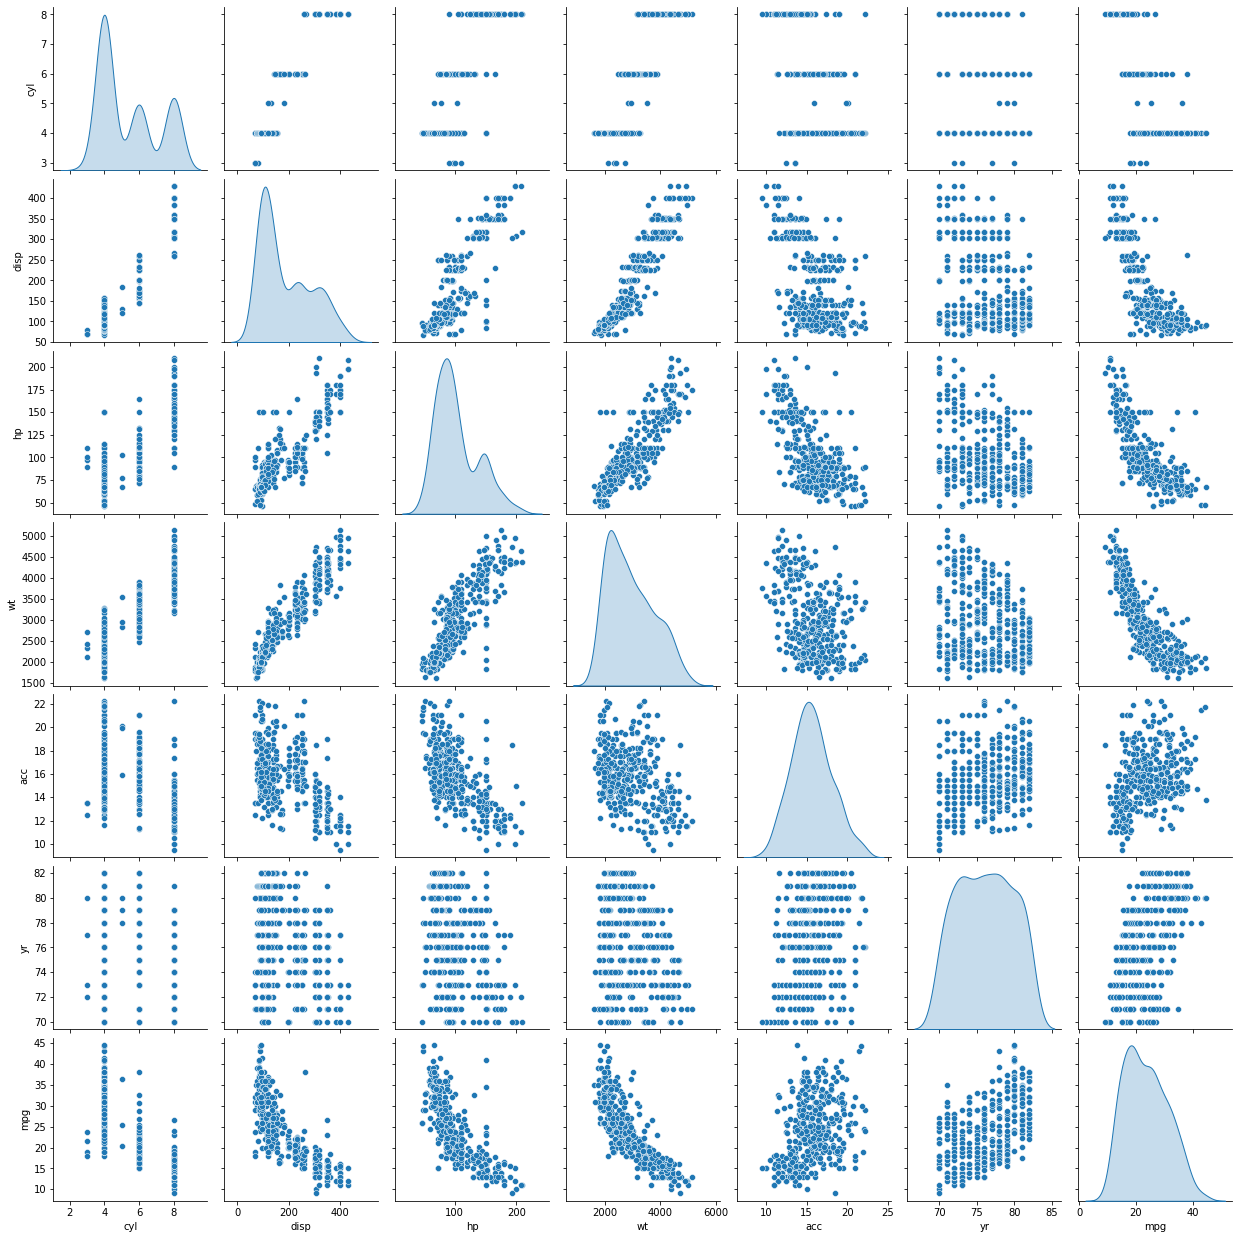

In [17]:
# Pairplot of all the columns
sns.pairplot(cars, diag_kind="kde")

As can be seen from the pair plots there are few overlapping gaussian curves. Some of the features provide very distinct gaussian curves- peaks like - cyl, disp and hp. The others are not showing distinct curves. The feature acc is a poor feature as it has got just 1 gaussian and may not be a good feature for classification.

Overall with the feature cyl we can see the most number of and most distinct curves. We can see 3 distinct curves suggesting we may have 3 classes in place.

Also we can observe the following:
1. disp has postive co-relation with hp and wt  and a negative corelation with mpg
2. hp as positive corelation with disp and wt and negative corelation with acc and mpg
3. wt has positive corelation with disp and hp and negative corelation with mpg
4. acc has slightly negative corelation with disp and hp
5. year has no corelation with any of the features - This may also be attributed to the fact that its a discreate variable column
6. mpg has negative corelation with disp, hp, wt and a  very slight positive relation with acc.



### Use K Means or Hierarchical clustering

#### Using K-Means clustering

In [18]:
# Scaling the data for K-means clustering
cars_scaled = cars.drop('car name', axis=1).apply(zscore)

In [19]:
cars_scaled.head()

,cyl,disp,hp,wt,acc,yr,mpg
0,1.549385,1.197019,0.779629,0.673657,-1.453789,-1.682329,-0.740829
1,1.549385,1.632225,1.789576,0.901487,-1.654641,-1.682329,-1.137738
2,1.549385,1.308351,1.356742,0.591687,-1.855493,-1.682329,-0.740829
3,1.549385,1.166656,1.356742,0.588070,-1.453789,-1.682329,-1.005435
4,1.549385,1.146414,1.068185,0.607357,-2.056344,-1.682329,-0.873132


In [20]:
cluster_range = range( 1, 15 )
cluster_errors = []
for num_clusters in cluster_range:
  clusters = KMeans( num_clusters,n_init = 15, random_state=2)
  clusters.fit(cars_scaled)
  labels = clusters.labels_
  centroids = clusters.cluster_centers_
  cluster_errors.append( clusters.inertia_ )
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )
clusters_df[0:15]

,num_clusters,cluster_errors
0,1,2681.000000
1,2,1298.791750
2,3,945.773092
3,4,740.547953
4,5,661.931357
5,6,606.086065
6,7,552.407515
7,8,502.632253
8,9,461.048905
9,10,436.999437


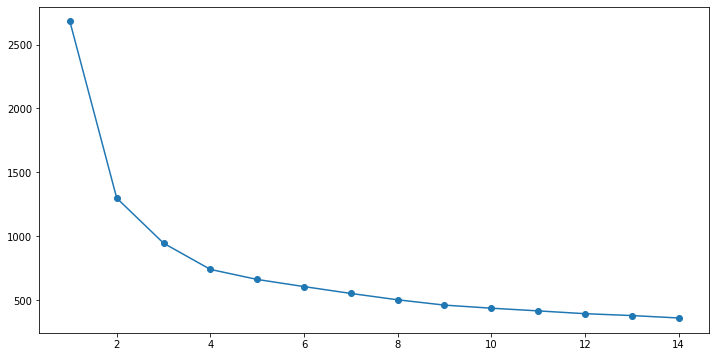

In [21]:
# Elbow plot

plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

From the plot above we can see that there can be upto 3 or 4 classes as till 3 or 4 classes there is steep decline in the error and later we can see that the slope reduces, suggesting that there can be 3-4 classes classified in the data set.

In [22]:
cluster = KMeans( n_clusters = 3, random_state = 1 )
cluster.fit(cars_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

In [23]:
prediction=cluster.predict(cars_scaled)
KMeans_3Classes = cars
KMeans_3Classes["GROUP"] = prediction

In [24]:
KMeans_3Classes.groupby("GROUP").count()

,car name,cyl,disp,hp,wt,acc,yr,mpg
GROUP,,,,,,,,
0,201,201,201,201,201,201,201,201
1,87,87,87,87,87,87,87,87
2,95,95,95,95,95,95,95,95


In [25]:
cluster = KMeans( n_clusters = 4, random_state = 1 )
cluster.fit(cars_scaled)
prediction=cluster.predict(cars_scaled)
KMeans_4Classes = cars
KMeans_4Classes["GROUP"] = prediction
KMeans_4Classes.groupby("GROUP").count()

,car name,cyl,disp,hp,wt,acc,yr,mpg
GROUP,,,,,,,,
0,98,98,98,98,98,98,98,98
1,87,87,87,87,87,87,87,87
2,107,107,107,107,107,107,107,107
3,91,91,91,91,91,91,91,91


#### Using hierarchial clustering

In [26]:
# cophenet index is a measure of the correlation between the distance of points in feature space and distance on dendrogram
# closer it is to 1, the better is the clustering

Z = linkage(cars_scaled, 'average')
c, coph_dists = cophenet(Z , pdist(cars_scaled))

c

0.7864428737820072

In [27]:
Z.shape

(382, 4)

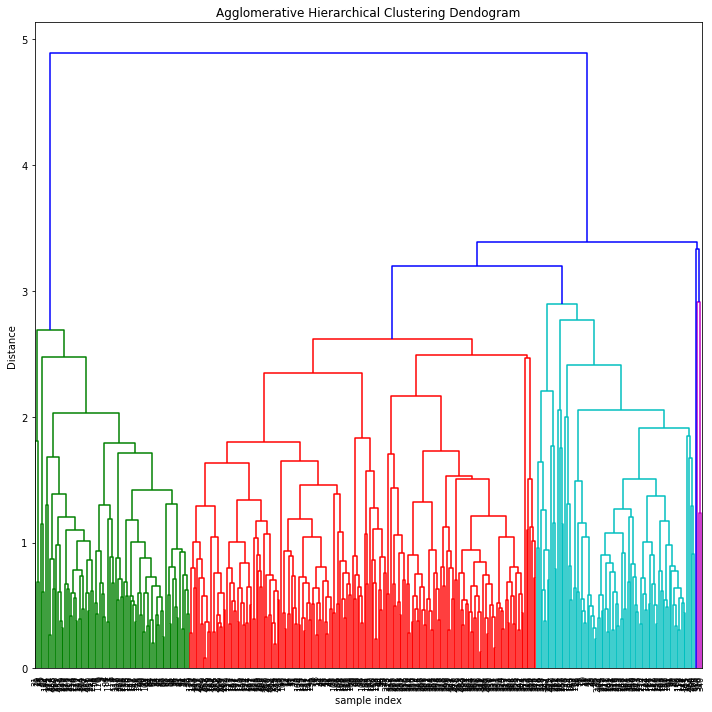

In [28]:
plt.figure(figsize=(10, 10))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90.,color_threshold = 3, leaf_font_size=8. )
plt.tight_layout()

With linkage method as average and method as average we can observe that there can be 3 distinct custers in this case.
The cophenet value is .7864

In [29]:
Z = linkage(cars_scaled, 'complete')
c, coph_dists = cophenet(Z , pdist(cars_scaled))
c

0.6658310862670405

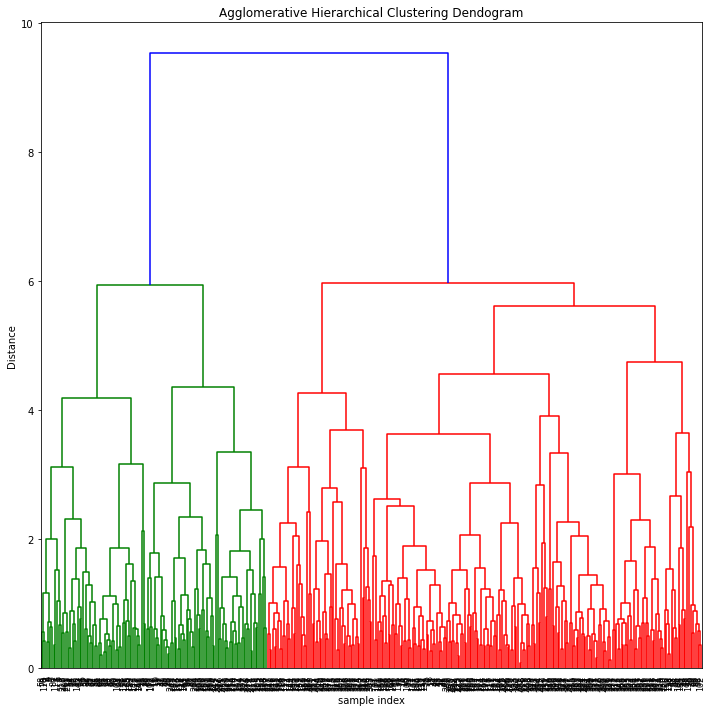

In [30]:
plt.figure(figsize=(10, 10))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90.,color_threshold = 6, leaf_font_size=8. )
plt.tight_layout()

From above we can observe that there are 2 distinct clusters if we do complete linkage as can be seen by 2 colors.

The cophenet value is .6658

In [31]:
Z = linkage(cars_scaled, 'ward')
c, coph_dists = cophenet(Z , pdist(cars_scaled))
c

0.7721824500229262

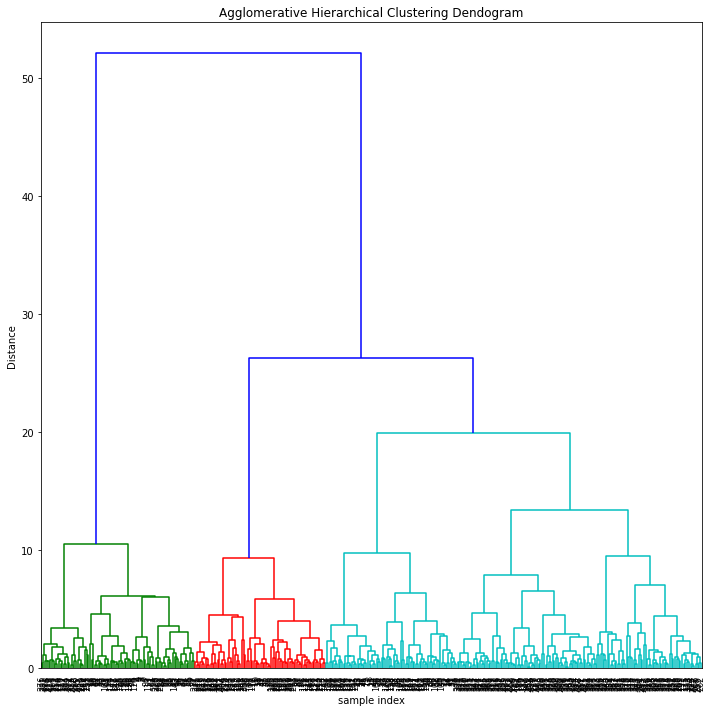

In [32]:
plt.figure(figsize=(10, 10))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90.,color_threshold = 20, leaf_font_size=8. )
plt.tight_layout()

From above we can observe that there are 3 distinct cluusters if we do ward linkage as can be seen by 3 colors.

The cophenet value is .7721

In [33]:
 model = AgglomerativeClustering(n_clusters=3, affinity='euclidean',  linkage='ward')

In [34]:
model.fit(cars_scaled)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=3)

In [35]:
cars_labeled = cars

In [36]:
cars_labeled['GROUP'] = model.labels_

In [37]:
cars_labeled.groupby(["GROUP"]).count()

,car name,cyl,disp,hp,wt,acc,yr,mpg
GROUP,,,,,,,,
0,218,218,218,218,218,218,218,218
1,89,89,89,89,89,89,89,89
2,76,76,76,76,76,76,76,76


#### Summary

As we can see there are 3 classes that has been identified by both the models:

1. From the Elbow curve from the K-Means model we couls see that the drop in error was mostly till 3 or 4 clusters then the drop becomes slow, suggesting there could be 3 or 4 clusters, however till 3rd cluster the drop rate was much higher hence we can go with 3 clusters. There are  201, 87 and 95 elements in the 3 identified clusters.
2. Using the hierarchial modeling we can see that there are 3 distinct clusters by using any of the approaches (average/ ward ). We can see that the cophenet value was highest with average linkage hence we c an go kwith average linkage for modelling. We have 3 clusters with 218, 89 and 76 elements in the cluster.

### Use linear regression model on different clusters separately and print the coefficients of the models

#### Analysing the KMeans cluster

In [38]:
KMeans_GRP_0 = KMeans_3Classes[KMeans_3Classes.GROUP == 0]
KMeans_GRP_1 = KMeans_3Classes[KMeans_3Classes.GROUP == 1]
KMeans_GRP_2 = KMeans_3Classes[KMeans_3Classes.GROUP == 2]

In [39]:
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(KMeans_GRP_0.iloc[:,1:-2],  KMeans_GRP_0['mpg'], train_size=.7,random_state=1)

In [40]:
model=LinearRegression(fit_intercept=True)
model.fit(X_train_0, y_train_0)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [41]:
print("Score for class 0:", model.score(X_test_0, y_test_0))

Score for class 0: 0.5680298718241148


In [42]:
print("Coefficient for class 0", model.coef_)

Coefficient for class 0 [ 1.28037955 -0.03252794 -0.03664321 -0.00729795  0.05296879  0.83189506]


In [43]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(KMeans_GRP_1.iloc[:,1:-2],  KMeans_GRP_1['mpg'], train_size=.7,random_state=1)
model=LinearRegression(fit_intercept=True)
model.fit(X_train_1, y_train_1)
print("Score for class 1:", model.score(X_test_1, y_test_1))
print("Coefficient for class 1", model.coef_)

Score for class 1: 0.7091643470914661
Coefficient for class 1 [ 0.         -0.00755267 -0.03640097 -0.00101774 -0.40626931  0.32398033]


In [44]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(KMeans_GRP_2.iloc[:,1:-2],  KMeans_GRP_2['mpg'], train_size=.7,random_state=1)
model=LinearRegression(fit_intercept=True)
model.fit(X_train_2, y_train_2)
print("Score for class 2:", model.score(X_test_2, y_test_2))
print("Coefficient for class 2", model.coef_)

Score for class 2: 0.11042670329283133
Coefficient for class 2 [ 2.55788402  0.00408874  0.00308238 -0.00477612  0.02598036  0.29604079]
